## Data Science Project: Predicting StreetEasy Rent Prices

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import re

from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel, RFE
from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import  mean_squared_error
from sklearn.model_selection import KFold, train_test_split, GridSearchCV

## Load The Data

In [4]:
# training data with its park and school data
test1_df = pd.read_csv('./csv/SE_rents2018_test1.csv')
train_df = pd.read_csv('./csv/SE_rents2018_train.csv')
train_park_df = pd.read_csv('./csv/number_of_parks_updated.csv')
train_school_df = pd.read_csv('./csv/number_of_schools.csv')

# test2 data and its park and school data
test2_df = pd.read_csv('./csv/SE_rents2018_test2.csv')
test2_park_df = pd.read_csv('./csv/test2_parks.csv')
test2_school_df = pd.read_csv('./csv/test2_schools.csv')

price_sqft_df = pd.read_csv('./csv/neighborhood_price_sqrt.csv')
zipcode_df = pd.read_csv('./csv/zip_codes.csv', index_col=0)
schools_df = pd.read_csv('./csv/school_info.csv', index_col=0)

In [5]:
# Append test1 to train_df
train_df = train_df.append(test1_df, ignore_index = True)

# # merge price_sqft to train_df
train_df = pd.merge(left=train_df, right=price_sqft_df, left_on='neighborhood', right_on='neighborhood', how='left')
train_df.head()

# merge zipcode to train_df
train_df = pd.merge(left=train_df, right=zipcode_df, left_on='addr_zip', right_index=True)
train_df.reset_index(drop=True, inplace=True)

# merge school info to train_df
train_df = pd.merge(left=train_df, right=schools_df, left_on='addr_zip', right_index=True)
train_df

,rental_id,addr_unit,building_id,bedrooms,bathrooms,size_sqft,created_at,addr_street,addr_city,addr_zip,...,AverageFamilySize,Avg_num_students,Avg_rank,Avg_elem_rank,Num_high_schools,Num_middle_schools,Num_elem_schools,Num_private_schools,Num_Other,Avg_ST_Ratio
0,7236931,#22A,551248,4,3.0,1300.0,2018-06-04 16:31:06,645 OCEAN AVENUE,Brooklyn,11226,...,3.41,420.400000,30.678824,32.584444,5.0,3.0,9.0,2.0,1.0,14.815000
1,7323106,#B23,548233,1,1.0,800.0,2018-07-01 12:15:36,199 LINDEN BOULEVARD,Brooklyn,11226,...,3.41,420.400000,30.678824,32.584444,5.0,3.0,9.0,2.0,1.0,14.815000
2,7316782,#6G,559180,1,1.0,750.0,2018-06-28 16:29:30,585 EAST 21 STREET,Brooklyn,11226,...,3.41,420.400000,30.678824,32.584444,5.0,3.0,9.0,2.0,1.0,14.815000
3,7148167,#1P,18771592,0,1.0,492.0,2018-05-04 16:04:18,125 PARKSIDE AVENUE,Brooklyn,11226,...,3.41,420.400000,30.678824,32.584444,5.0,3.0,9.0,2.0,1.0,14.815000
4,7293532,#2C,555277,1,1.0,785.0,2018-06-21 08:03:18,330 EAST 22 STREET,Brooklyn,11226,...,3.41,420.400000,30.678824,32.584444,5.0,3.0,9.0,2.0,1.0,14.815000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,7229170,#30,1083148,1,1.0,750.0,2018-06-01 15:38:15,1427 TAYLOR AVENUE,Bronx,10460,...,3.46,426.750000,13.469545,12.391818,5.0,6.0,11.0,1.0,1.0,12.358333
13996,7397476,#2,1917055,0,1.0,900.0,2018-07-24 14:18:44,192-11 JAMAICA AVENUE,Hollis,11423,...,3.58,550.285714,29.848000,37.480000,1.0,1.0,3.0,2.0,0.0,12.371429
13997,7510720,#2,1537258,2,1.0,1200.0,2018-08-25 22:02:09,13-01 125 STREET,College Point,11356,...,3.46,520.250000,48.223333,72.335000,0.0,1.0,2.0,1.0,0.0,14.066667
13998,7464709,NaN,2303125,3,2.0,1868.0,2018-08-10 13:57:18,5 COMMERCE STREET,Staten Island,10314,...,3.27,627.476190,64.712308,67.521250,3.0,2.0,8.0,8.0,0.0,13.228571


## Data Exploration

In [6]:
train_df.columns

Index(['rental_id', 'addr_unit', 'building_id', 'bedrooms', 'bathrooms',
       'size_sqft', 'created_at', 'addr_street', 'addr_city', 'addr_zip',
       'addr_lat', 'addr_lon', 'bin', 'bbl', 'floor_count', 'year_built',
       'min_to_subway', 'has_doorman', 'has_elevator', 'has_fireplace',
       'has_dishwasher', 'is_furnished', 'has_gym', 'allows_pets',
       'has_washer_dryer', 'has_garage', 'has_roofdeck', 'has_concierge',
       'has_pool', 'has_garden', 'has_childrens_playroom', 'rent', 'no_fee',
       'description', 'neighborhood', 'borough', 'unit', 'floornumber', 'line',
       'avg_price_per_sqft', 'ZipCodePopulation', 'WhitePop', 'BlackPop',
       'HispanicPop', 'AsianPop', 'IndianPop', 'HawaiianPop', 'MalePop',
       'FemalePop', 'AverageHouseValue', 'IncomePerHousehold', 'MedianAge',
       'MedianAgeMale', 'MedianAgeFemale', 'AverageFamilySize',
       'Avg_num_students', 'Avg_rank', 'Avg_elem_rank', 'Num_high_schools',
       'Num_middle_schools', 'Num_elem_schools

### Missing Data

In [7]:
cols_with_null = train_df.columns[train_df.isna().any()] # Return columns with null values 

train_df[cols_with_null].isna().sum().sort_values(ascending=False) # Number of null values 

line                  4135
avg_price_per_sqft    1562
floornumber           1502
year_built             470
min_to_subway          143
unit                   114
addr_unit              110
description             16
neighborhood             3
bin                      1
dtype: int64

Looks like there are a lot of missing values, especially for floornumber and line. However, from these missing values, it's likely that we will only use floornumber and floorcount for our final model, so we can focus on those.

### Data Distribution

In [8]:
cols = ['bedrooms', 'bathrooms', 'size_sqft', 'floor_count', 'floornumber', 'year_built', 'min_to_subway', 'rent']
train_df[cols].describe()

,bedrooms,bathrooms,size_sqft,floor_count,floornumber,year_built,min_to_subway,rent
count,14000.000000,14000.000000,14000.000000,14000.000000,12498.000000,13530.000000,13857.000000,14000.000000
mean,1.661643,1.238929,848.388643,10.233350,6.198232,1935.773023,63.597067,3591.997214
std,1.084151,0.550979,513.039489,12.003629,7.728606,159.019577,2482.437096,2874.099247
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016700,1250.000000
25%,1.000000,1.000000,604.000000,3.000000,2.000000,1915.000000,1.633300,2250.000000
50%,2.000000,1.000000,800.000000,5.000000,3.000000,1931.000000,2.766700,2900.000000
75%,2.000000,1.000000,1000.000000,12.000000,6.000000,1987.000000,4.383300,3900.000000
max,8.000000,20.000000,10000.000000,90.000000,78.000000,2019.000000,103343.616700,50000.000000


A quick glance at the distribution of these columns tells us a couple things
- It's possible some of the columns are skewed
- There are some fishy values here
    - 20 bathrooms
    - 0 size_sqft
    - 0 floor_count

Let's look at the histogram for these columns to reaffirm some of our observations

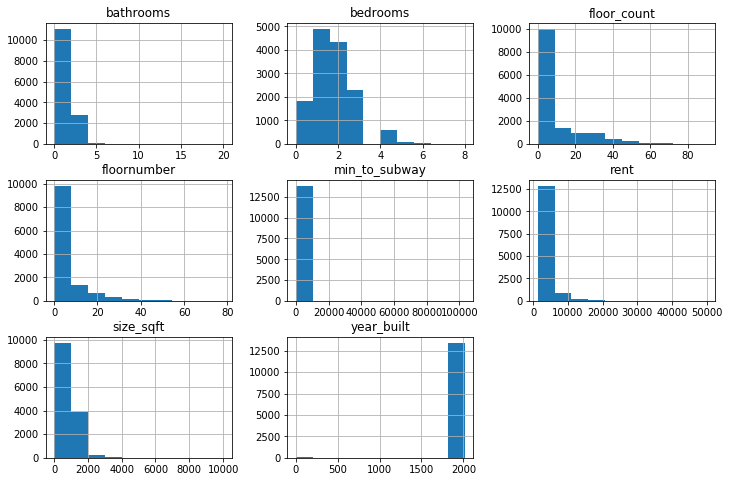

In [228]:
train_df[cols].hist(figsize=(12,8))
plt.show()

### Observations
- As we thought, many of these columns are right skewed.
- There are many outliers present in many of these columns, which may be legit in some cases, but some of them make no sense and will have to be dealt with.


### Visualizing Rent Prices

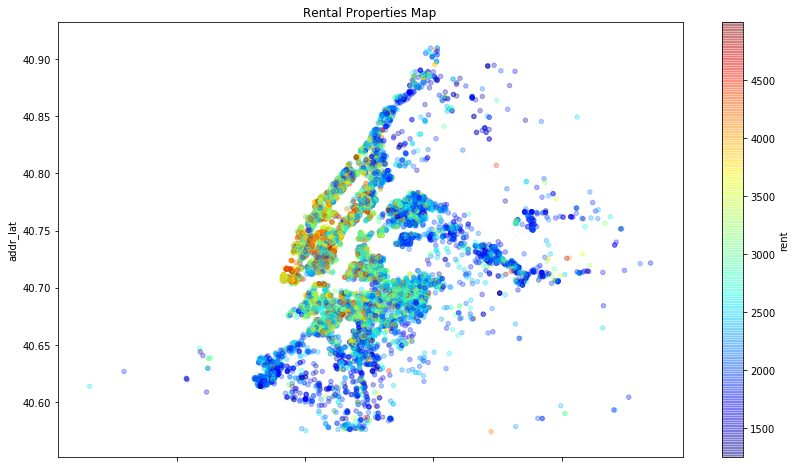

In [229]:
# Most rent prices fall under 5000, so we want to visualize where these places are in NYC
train_df[(train_df['rent'] < 5000) ].plot(x='addr_lon', y='addr_lat', kind='scatter', alpha=0.3, c='rent', cmap=plt.get_cmap("jet"), colorbar=True, figsize=(14,8))
plt.title('Rental Properties Map')
plt.show()

### Observations
- As expected, most of the higher end rent prices are in Manhattan.
- High rent prices outside of Manhattan still tend to be close to Manhattan.
- Rent prices seem to be fairly high in an area that looks like it's near Battery Park.
- Rent prices are pretty low in the south side of Brooklyn, Bronx, and the east side of Queens.

In [230]:
top_25 = train_df.groupby('neighborhood').median()['rent'].sort_values(ascending=False).head(25)
top_25

neighborhood
Tribeca                            7500.0
Soho                               6800.0
Central Park South                 5675.0
Nolita                             5200.0
Flatiron                           4691.0
DUMBO                              4587.5
Midtown                            4500.0
Greenwich Village                  4500.0
Chelsea                            4474.0
Hillcrest                          4399.5
Stuyvesant Town/PCV                4049.5
West Village                       4000.0
Columbia St Waterfront District    4000.0
Midtown South                      3989.0
Battery Park City                  3911.0
Upper West Side                    3750.0
Morningside Heights                3650.0
Upper East Side                    3600.0
Utopia                             3600.0
Financial District                 3595.0
Midtown East                       3553.0
Gramercy Park                      3500.0
Lower East Side                    3500.0
Midtown West         

In [231]:
train_df['Top25_neighborhood'] = train_df.neighborhood.apply(lambda x: x if x in top_25.index else 'Trash')

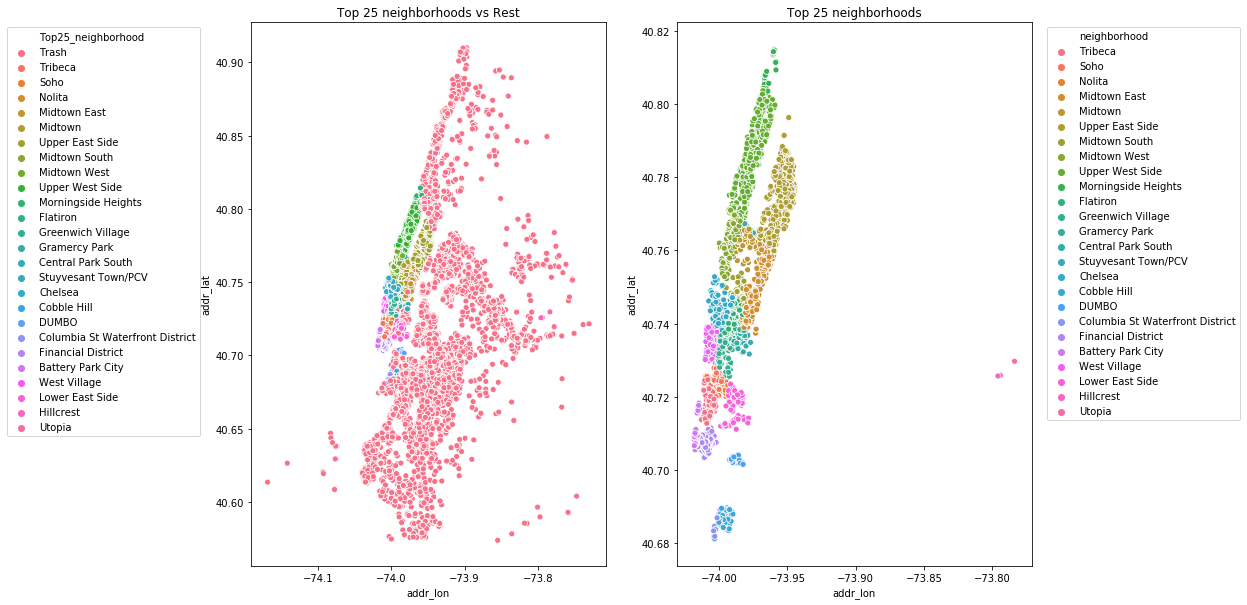

In [232]:
fig, ax = plt.subplots(1,2, figsize=(14,10))

sns.scatterplot(x='addr_lon', y ='addr_lat', data=train_df, hue='Top25_neighborhood', ax=ax[0])
ax[0].legend(loc='upper left', bbox_to_anchor=(-0.7,1))
ax[0].set_title('Top 25 neighborhoods vs Rest')

sns.scatterplot(x='addr_lon', y ='addr_lat' ,data = train_df[train_df['Top25_neighborhood'] != 'Trash'], hue='neighborhood', ax=ax[1])
ax[1].legend(loc='upper right', bbox_to_anchor=(1.6,1))
ax[1].set_title('Top 25 neighborhoods')

plt.show()

#### The top 20 list, as well as the map, gives us an idea of "hot" neighborhoods. 
- The left map gives an idea of where these top 20 neighborhoods are in comparison to the others.
- The right map gives a more focused version containing only the top 20 neighborhoods.
- Using these maps we can hopefully pinpoint the geographic features, as well as neighborhood features, that make a given neighborhood popular.

In [233]:
train_df.drop(columns=['Top25_neighborhood'], inplace=True)

## Data Cleaning

In [9]:
# Abstracted Data Cleaning Functions
import external_funcs as ef

### Duplicate Data

In [10]:
# Look for duplcated data based on defaults 
defaults = [
    'size_sqft', 'bathrooms', 'bedrooms','neighborhood','addr_street','addr_lat' ,'addr_lon','rent','borough', 'addr_unit']

train_df[train_df.duplicated(subset=defaults)].head(3)

,rental_id,addr_unit,building_id,bedrooms,bathrooms,size_sqft,created_at,addr_street,addr_city,addr_zip,...,AverageFamilySize,Avg_num_students,Avg_rank,Avg_elem_rank,Num_high_schools,Num_middle_schools,Num_elem_schools,Num_private_schools,Num_Other,Avg_ST_Ratio
149,7132897,#A14,559234,2,1.0,1000.0,2018-05-01 10:43:28,2215 NEWKIRK AVENUE,Brooklyn,11226,...,3.41,420.4,30.678824,32.584444,5.0,3.0,9.0,2.0,1.0,14.815
153,7373401,#4C,560314,3,1.0,1200.0,2018-07-17 10:02:44,2110 NEWKIRK AVENUE,Brooklyn,11226,...,3.41,420.4,30.678824,32.584444,5.0,3.0,9.0,2.0,1.0,14.815
172,7383490,#2K,546328,1,1.0,800.0,2018-07-19 14:22:09,25 PARADE PLACE,Brooklyn,11226,...,3.41,420.4,30.678824,32.584444,5.0,3.0,9.0,2.0,1.0,14.815


In [11]:
# drop duplicated values
train_df.drop_duplicates(subset=defaults, inplace=True)
train_df.reset_index(drop=True, inplace=True)

### Outlier Data

In [12]:
# outliers identified
outliers1 = train_df.loc[(train_df.size_sqft < 1000) & (train_df.rent > 10000), ['rent', 'size_sqft']]
outliers2 = train_df.loc[(train_df.size_sqft < 2000) & (train_df.rent > 40000), ['rent', 'size_sqft']]
outliers3 = train_df.loc[(train_df.size_sqft < 200) | (train_df.size_sqft > 8000), ['rent', 'size_sqft']]
outliers = outliers1.append(outliers2).append(outliers3)

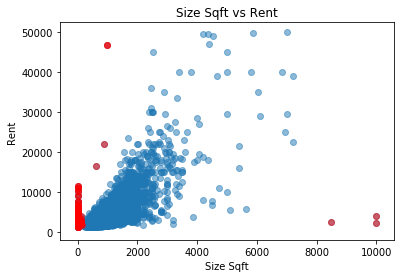

In [13]:
_ = plt.figure()
plt.scatter(x=train_df['size_sqft'], y=train_df['rent'], alpha=0.5)
plt.scatter(x=outliers['size_sqft'], y=outliers['rent'], c='red', alpha=0.5)
plt.xlabel('Size Sqft')
plt.ylabel('Rent')
plt.title('Size Sqft vs Rent')
plt.show()

In [14]:
# Dropping outliers
train_df.drop(train_df.loc[(train_df.size_sqft < 1000) & (train_df.rent > 10000)].index, inplace=True)
train_df.drop(train_df.loc[(train_df.size_sqft < 200) & (train_df.size_sqft > 0)].index, inplace=True)
train_df.drop(train_df.loc[(train_df.size_sqft < 2000) & (train_df.rent > 40000)].index, inplace=True)
train_df.drop(train_df.loc[train_df.size_sqft > 8000].index, inplace=True)
train_df.reset_index(drop=True, inplace=True)

In [15]:
train_df.drop(train_df.loc[train_df.min_to_subway > 60].index, inplace=True)
train_df.reset_index(drop=True, inplace=True)

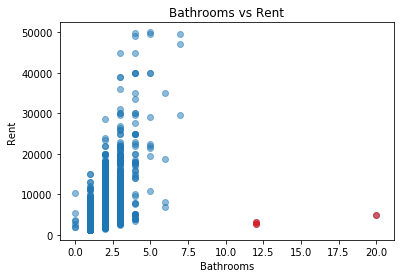

In [16]:
_ = plt.figure()
plt.scatter(x=train_df['bathrooms'], y=train_df['rent'], alpha=0.5)
plt.scatter(x=train_df.loc[train_df['bathrooms'] > 7, 'bathrooms'], y=train_df.loc[train_df['bathrooms'] > 7, 'rent'], c='red', alpha=0.5)
plt.xlabel('Bathrooms')
plt.ylabel('Rent')
plt.title('Bathrooms vs Rent')
plt.show()

In [17]:
train_df.drop(train_df.loc[train_df.bathrooms > 7].index, inplace=True)
train_df.reset_index(drop=True, inplace=True)

In [18]:
# add one to account for the fact that there are floor_count of 0 
train_df['floor_ratio'] = (train_df['floornumber'] + 1) / (train_df['floor_count'] + 1)

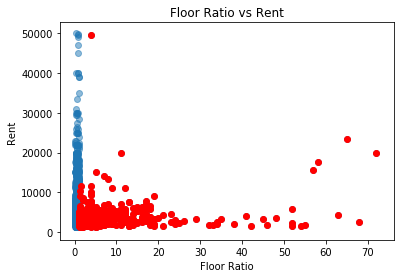

In [19]:
_ = plt.figure()
plt.scatter(x=train_df['floor_ratio'], y=train_df['rent'], alpha=0.5)
plt.scatter(x=train_df.loc[train_df['floor_ratio'] > 1, 'floor_ratio'], y=train_df.loc[train_df['floor_ratio'] > 1, 'rent'], c='red')
plt.xlabel('Floor Ratio')
plt.ylabel('Rent')
plt.title('Floor Ratio vs Rent')
plt.show()

### Missing Data

In [20]:
train_df.loc[train_df['size_sqft'] == 0, 'size_sqft'] = np.NaN

In [21]:
# add min_to_subway
train_df['min_to_subway'] = ef.fill_mins_to_subway(train_df)

# add missing size sqrt
sqft_model = ef.train_sqft_model(train_df)

train_df['size_sqft'] = ef.fill_size_sqft(train_df, sqft_model)

# fill price_per_sqft with the average price per sqft for the borough
train_df['avg_price_per_sqft'] = ef.fill_price_per_sqft(train_df)

<class 'pandas.core.series.Series'>


## Feature Engineering

### Description Mining

In [22]:
train_df.loc[train_df['description'].isna(), 'description'] = ""

train_df['description'] = train_df.description.apply(lambda x: x.lower())

train_df['is_studio'] = train_df.description.str.contains(r'studio').astype('int')

train_df['has_hardwood_flr'] = train_df.description.str.contains(r'hardwood floor').astype('int')

train_df['has_high_ceilings'] = train_df.description.str.contains(r'high-ceiling|high ceiling|high cieling|high celing|high ceilng|tall ceiling| tall-ceiling').astype('int')

train_df['is_renovated'] = train_df.description.str.contains(r'renovated').astype('int')

### Top 25 Neighborhoods

In [23]:
top_25 = train_df.groupby('neighborhood').median()['rent'].sort_values(ascending=False).head(25)
train_df['is_top25_neighborhood'] = train_df.neighborhood.apply(lambda x: 1 if x in top_25.index else 0)

### Population Ratios

In [24]:
ef.get_population_ratios(train_df)

In [25]:
train_df.columns

Index(['rental_id', 'addr_unit', 'building_id', 'bedrooms', 'bathrooms',
       'size_sqft', 'created_at', 'addr_street', 'addr_city', 'addr_zip',
       'addr_lat', 'addr_lon', 'bin', 'bbl', 'floor_count', 'year_built',
       'min_to_subway', 'has_doorman', 'has_elevator', 'has_fireplace',
       'has_dishwasher', 'is_furnished', 'has_gym', 'allows_pets',
       'has_washer_dryer', 'has_garage', 'has_roofdeck', 'has_concierge',
       'has_pool', 'has_garden', 'has_childrens_playroom', 'rent', 'no_fee',
       'description', 'neighborhood', 'borough', 'unit', 'floornumber', 'line',
       'avg_price_per_sqft', 'ZipCodePopulation', 'WhitePop', 'BlackPop',
       'HispanicPop', 'AsianPop', 'IndianPop', 'HawaiianPop', 'MalePop',
       'FemalePop', 'AverageHouseValue', 'IncomePerHousehold', 'MedianAge',
       'MedianAgeMale', 'MedianAgeFemale', 'AverageFamilySize',
       'Avg_num_students', 'Avg_rank', 'Avg_elem_rank', 'Num_high_schools',
       'Num_middle_schools', 'Num_elem_schools

### Others

In [26]:
train_df['number_of_privileges'] = ef.number_privileges(train_df)
train_df['number_of_parks'] = ef.number_of_parks(train_park_df, train_df)
train_df['number_of_schools'] = ef.number_of_schools(train_school_df, train_df)
train_df['park_level'] = ef.park_level(train_df)
train_df['school_level'] = ef.school_level(train_df)

## Feature Selection

In [27]:
# Find all columns that have Pop in the name
r = re.compile(r".*Pop$")
populations = list(filter(r.match, train_df.columns))

In [28]:
# Find all privileges
r  = re.compile(r"has_.*")
has_ = list(filter(r.match, train_df.columns))

In [29]:
# Transform boroughs into boolean columns
train_df = pd.get_dummies(train_df, columns=['borough'])

In [30]:
# Separate holdout set here before we do any feature selection
model_train_df, model_holdout_df = train_test_split(train_df, test_size=0.2)
model_train_df.reset_index(inplace=True, drop=True)
model_holdout_df.reset_index(inplace=True, drop=True)

In [31]:
# Seperate out columsn we believe are irrelevant
trash_cols = ['rental_id', 'addr_unit', 'building_id','created_at', 'addr_street', 'addr_city', 'addr_zip',
       'addr_lat', 'addr_lon', 'bin', 'bbl', 'description', 'neighborhood', 'unit','line', 'year_built','floornumber', 'floor_count',
             'floor_ratio']
trash_cols.extend(populations)
trash_cols.extend(has_)
df_selection = model_train_df.drop(columns=trash_cols)

### Correlation Feature Selection

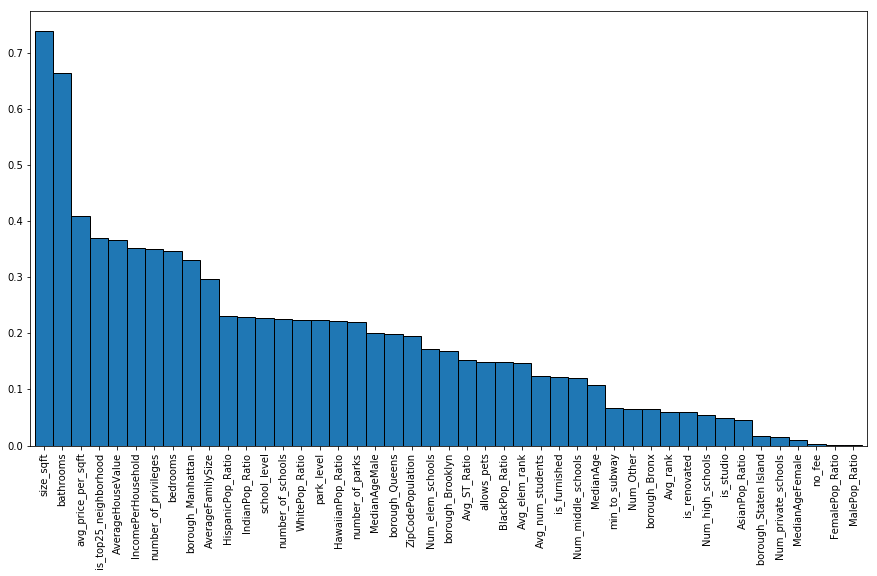

In [169]:
rent_corr = abs(df_selection.corr()['rent']).sort_values(ascending=False)[1:]
rent_corr.plot(kind='bar', width=1, edgecolor = 'k', figsize=(15,8))

### Chi2 Test

In [170]:
X = df_selection.drop('rent', axis=1)
y = df_selection['rent']
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

chi2_feats = featureScores.nlargest(20,'Score')['Specs']

### Lasso Regression Test

In [171]:
mm_scaler = preprocessing.MinMaxScaler()
X_scaled = mm_scaler.fit_transform(X)

embeded_lasso_selector = SelectFromModel(Lasso(), max_features=20)
embeded_lasso_selector.fit(X_scaled, y)

embeded_lasso_support = embeded_lasso_selector.get_support()
embeded_lasso_feature = X.loc[:,embeded_lasso_support].columns.tolist()

TypeError: __init__() got an unexpected keyword argument 'max_features'

### RFE Test

In [55]:
rfe_selector = RFE(estimator=DecisionTreeRegressor(max_depth=10), n_features_to_select=20, step=10, verbose=5)
rfe_selector.fit(X, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

Fitting estimator with 45 features.
Fitting estimator with 35 features.
Fitting estimator with 25 features.


### RF Feature Importance

In [56]:
embeded_rf_selector = SelectFromModel(RandomForestRegressor(n_estimators=100), max_features=20)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

### LGBM Feature Importance

In [57]:
lgbc=LGBMRegressor(n_estimators=100, learning_rate=0.1, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=20)
embeded_lgb_selector.fit(X, y)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()

In [58]:
def comparison(l1,l2):
    res = []
    for feature in l1:
        if feature in l2:
            res.append(True)
        else:
            res.append(False)
    return res

In [59]:
# Find which features are in the top 20 features for each test
correlation = comparison(X.columns, rent_corr[:21])
chi = comparison(X.columns, chi2_feats.values)
lasso_feat = comparison(X.columns, embeded_lasso_feature)
RFE_DT = comparison(X.columns, rfe_feature)
rforest_feat = comparison(X.columns, embeded_rf_feature)
embeded_lgb = comparison(X.columns, embeded_lgb_feature)

In [60]:
# Create a DataFrame to observe results
feature_selection_df = pd.DataFrame(index=X.columns, data={'Pearson':correlation, 'Chi-2':chi, 'Lasso':lasso_feat,
                                    'RFE_DT':RFE_DT,'Random Forest':rforest_feat, 'LightGBM':embeded_lgb})
feature_selection_df['Total'] = feature_selection_df.sum(axis=1)
feature_selection_df.sort_values(by='Total', ascending=False)

,Pearson,Chi-2,Lasso,RFE_DT,Random Forest,LightGBM,Total
size_sqft,True,True,True,True,True,True,6
avg_price_per_sqft,True,True,True,True,True,True,6
number_of_privileges,True,True,True,True,True,True,6
bedrooms,True,True,True,True,False,True,5
is_top25_neighborhood,True,True,True,True,True,False,5
AverageHouseValue,True,True,True,True,False,True,5
IncomePerHousehold,True,True,False,True,True,True,5
min_to_subway,False,True,True,True,False,True,4
bathrooms,True,False,True,True,True,False,4
number_of_parks,True,True,False,True,False,True,4


## Model Training

In [251]:
# Cross validation Function for classifer

def get_cv_results(classifier, train_df):
    results = []
    k_fold = KFold(n_splits=10)
    
    for train, test in k_fold.split(train_df):
        classifier.fit(train_df.loc[train, features], train_df.loc[train, 'rent'])
        y_predicted = classifier.predict(train_df.loc[test, features])
        accuracy = mean_squared_error(train_df.loc[test, 'rent'], y_predicted)
        results.append(accuracy)
    return np.mean(results), np.std(results)

### Feature Selection

In [63]:
features = [
    'size_sqft', 'avg_price_per_sqft','bathrooms', 'bedrooms', 'number_of_privileges', 'IncomePerHousehold', 
    'ZipCodePopulation', 'borough_Manhattan', 'is_top25_neighborhood'
]

## Model Selection

### linear Models

In [174]:
# Linear Regression
linear = LinearRegression()
get_cv_results(linear, model_train_df)

(2203613.997381048, 495566.95720062073)

In [175]:
# Lasso Regressor
LR = Lasso()
get_cv_results(LR, model_train_df)

(2203635.0904468815, 495964.03137867333)

### Ensemble Models

In [176]:
# Random Forest
rforest = RandomForestRegressor(max_depth=7,n_estimators=100)
get_cv_results(rforest, model_train_df)

(1290201.349410951, 373434.36242074514)

In [177]:
# Ada Boosting
ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=7),learning_rate=.1)
get_cv_results(ada, model_train_df)

(1263477.5384399586, 329114.9203920869)

In [178]:
# Gradient Boost
gbm = GradientBoostingRegressor(
    max_depth=5,
    n_estimators=100
)

get_cv_results(gbm, model_train_df)

(1053158.9171114746, 359804.72291802027)

## Grid Search

In [179]:
rf = RandomForestRegressor()

In [180]:
gbm = GradientBoostingRegressor()

In [181]:
param_grid_rf = {
    'max_depth':[10,20,30],
    'max_features': [2, 3, 4],
    'n_estimators': [100, 200, 300]
}

param_grid_gbm = {
    'max_depth':[10, 20, 30],
    'max_features': [2, 3, 4],
    'n_estimators': [100, 200, 300],
}

In [182]:
gs_rf = GridSearchCV(estimator = rf, param_grid = param_grid_rf, scoring = 'neg_mean_squared_error', cv = 5, n_jobs=-1)
gs_gbm = GridSearchCV(estimator = gbm, param_grid = param_grid_gbm, scoring = 'neg_mean_squared_error', cv = 5, n_jobs=-1)

grids = [gs_rf, gs_gbm]

In [183]:
best_params = []
best_score = []
MSE = []

In [184]:
for gs in grids:
    gs.fit(train_df[features], train_df['rent'])
    best_params.append(gs.best_params_)
    best_score.append(gs.best_score_)
    predicted = gs.predict(train_df[features])
    MSE.append(mean_squared_error(train_df['rent'], predicted))

In [186]:
models = ['Random Forest', 'Gradient Boosted Machine']
scores = zip(best_params, best_score, MSE)
scores = pd.DataFrame(scores, index=models)
scores.rename(columns={0:'Best Parameters',
                       1:'Training Accuracy',
                       2:'MSE'}, inplace=True)
display(scores)
print('Best Test Accuracy is %s\n with parameters %s' % (scores['MSE'].idxmax(),
                                                         scores.loc[scores['MSE'].idxmax()]['Best Parameters']))

,Best Parameters,Training Accuracy,MSE
Random Forest,"{'max_features': 3, 'max_depth': 10, 'n_estima...",-1.282002e+06,480115.778278
Gradient Boosted Machine,"{'max_features': 3, 'max_depth': 20, 'n_estima...",-1.326652e+06,3773.779847


Best Test Accuracy is Random Forest
 with parameters {'max_features': 3, 'max_depth': 10, 'n_estimators': 100}


### Test with Holdout Set

In [194]:
scores['Best Parameters'].iloc[1]

{'max_depth': 20, 'max_features': 3, 'n_estimators': 300}

In [205]:
rforest = RandomForestRegressor(max_features=3,
                                max_depth=10,
                                n_estimators=100)

In [196]:
gbm = GradientBoostingRegressor(max_features=3,
                                max_depth=20,
                                n_estimators=300)

In [206]:
# best model
rforest.fit(model_train_df[features], model_train_df['rent'])
predicted = rforest.predict(model_holdout_df[features])

In [207]:
# Mean Square Error
mean_squared_error(model_holdout_df['rent'],predicted)

1065373.0844294652

In [208]:
# error interms of $ value (Root Mean Square Error)
mean_squared_error(model_holdout_df['rent'],predicted)**(1/2)

1032.169116196307

## Model Prediction with Test3

### Add Missing Data And Feature Engineering

In [50]:
test3_df = pd.read_csv('./csv/SE_rents2018_test3.csv')

In [51]:
# # merge price_sqft to train_df
test3_df = pd.merge(left=test3_df, right=price_sqft_df, left_on='neighborhood', right_on='neighborhood', how='left')

In [52]:
# merge zipcode to train_df
test3_df = pd.merge(left=test3_df, right=zipcode_df, left_on='addr_zip', right_index=True, how='left')
test3_df.reset_index(drop=True, inplace=True)

In [53]:
test3_df.fillna(test3_df.mean(), inplace=True)

In [54]:
test3_df.loc[test3_df['size_sqft'] == 0, 'size_sqft'] = np.NaN

In [55]:
test3_df['size_sqft'] = ef.fill_size_sqft(test3_df, sqft_model)

<class 'pandas.core.series.Series'>


In [56]:
test3_df.loc[test3_df['description'].isna(), 'description'] = ""

test3_df['description'] = test3_df.description.apply(lambda x: x.lower())

test3_df['is_studio'] = test3_df.description.str.contains(r'studio').astype('int')

test3_df['has_hardwood_flr'] = test3_df.description.str.contains(r'hardwood floor').astype('int')

test3_df['has_high_ceilings'] = test3_df.description.str.contains(r'high-ceiling|high ceiling|high cieling|high celing|high ceilng|tall ceiling| tall-ceiling').astype('int')

test3_df['is_renovated'] = test3_df.description.str.contains(r'renovated').astype('int')

In [57]:
top_25 = test3_df.groupby('neighborhood').median()['rent'].sort_values(ascending=False).head(25)
test3_df['is_top25_neighborhood'] = test3_df.neighborhood.apply(lambda x: 1 if x in top_25.index else 0)

In [58]:
ef.get_population_ratios(test3_df)

In [59]:
test3_df['number_of_privileges'] = ef.number_privileges(test3_df)

In [60]:
test3_df = pd.get_dummies(test3_df, columns=['borough'])

### Model Prediction

In [61]:
rforest_final = RandomForestRegressor(max_features=3,
                                max_depth=10,
                                n_estimators=100)

In [64]:
rforest_final.fit(train_df[features], train_df['rent'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=3, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [66]:
predicted = rforest_final.predict(test3_df[features])

In [67]:
test3_submission_df = pd.DataFrame(data = {'predictions': predicted}, index=test3_df['rental_id'])

test3_submission_df.to_csv('test3_submission.csv')
test3_submission_df.head(10)

,predictions
rental_id,
7455565,4090.147257
7473295,2747.077270
7459804,2654.400218
7456330,2548.886975
7443595,2624.449337
7502623,2881.739820
7459171,2962.923791
7447600,1990.948873
7505254,3329.314359


In [68]:
f = list(features)
test3_df[['rental_id'] + f].head(10)

,rental_id,size_sqft,avg_price_per_sqft,bathrooms,bedrooms,number_of_privileges,IncomePerHousehold,ZipCodePopulation,borough_Manhattan,is_top25_neighborhood
0,7455565,1200.000000,2.800000,2.0,4,3,51269.0,49896.0,0,1
1,7473295,800.000000,2.830000,1.0,1,5,36009.0,67053.0,0,1
2,7459804,525.000000,4.063742,1.0,0,10,99063.0,42870.0,1,0
3,7456330,750.000000,4.500000,1.0,2,0,57866.0,25484.0,0,0
4,7443595,487.000000,4.063742,1.0,0,8,109250.0,54183.0,1,0
5,7502623,681.277152,6.740000,1.0,1,0,104561.0,24090.0,1,0
6,7459171,750.000000,5.530000,1.0,1,2,126107.0,59283.0,1,0
7,7447600,284.000000,3.410000,1.0,0,3,39979.0,17416.0,1,1
8,7505254,980.000000,2.830000,1.0,2,7,34122.0,81677.0,0,1
9,7454620,1002.229828,2.800000,1.0,3,4,47170.0,78895.0,0,1
